In [1]:
from mlcv_py import make_mask_with_size, encode_mask_with_size
from mlcv_py import MULTICUT_CODEC as mc, PARTITION_CODEC as pc, OPTIMIZER as opt
import cv2
from pathlib import Path
import shutil
from tqdm import tqdm
from functools import partial
from batch import batch_execute

In [2]:
def run(imgs, pc_algorithm, quality: float):
    inputs = [(img, mc.ENSEMBLE, pc_algorithm, opt.GREEDY_GRID, quality) for img in imgs]
    masks = [t[0] for t in batch_execute("make_mask_with_size", inputs, cpu_count=2)]
    inputs = [(img, mask, mc.ENSEMBLE, pc_algorithm, True, quality) for img, mask in zip(imgs, masks)]
    return [t[1] for t in batch_execute("encode_mask_with_size", inputs)]

In [3]:
SRC_ROOT = Path("../data/splitimages/test")
def compute_total_sizes(algorithm, quality):
    ans = dict()
    for category_dir in tqdm(SRC_ROOT.glob("*")):
        if not category_dir.is_dir(): continue
        imgs = [cv2.imread(str(img_p), cv2.IMREAD_COLOR) for img_p in category_dir.glob("*.png")]
        ans[category_dir.name] = run(imgs, algorithm, quality)
    return ans

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compare_results(size_results1, size_results2, algorithm1_name, algorithm2_name, save_path=None, size_results3=None, algorithm3_name=None):
    """
    Compare compression results by category, plot a bar chart with relative reduction, and optionally save the chart.

    Args:
        size_results1 (dict): A dictionary mapping category names to a list of sizes (bits) for the first algorithm.
        size_results2 (dict): A dictionary mapping category names to a list of sizes (bits) for the second algorithm.
        algorithm1_name (str): Name of the first algorithm (baseline).
        algorithm2_name (str): Name of the second algorithm.
        save_path (str, optional): File path to save the chart. If None, the chart is not saved.
        size_results3 (dict, optional): A dictionary mapping category names to a list of sizes (bits) for the third algorithm.
        algorithm3_name (str, optional): Name of the third algorithm.
    """
    # Ensure all dictionaries have the same keys
    categories = sorted(set(size_results1.keys()).intersection(size_results2.keys()))
    
    # Calculate total sizes for each category
    total_sizes1 = [sum(size_results1[category]) for category in categories]
    total_sizes2 = [sum(size_results2[category]) for category in categories]
    if size_results3:
        total_sizes3 = [sum(size_results3[category]) for category in categories]
    
    # Calculate relative reduction for algorithm 2 and optionally algorithm 3 compared to algorithm 1
    relative_reduction2 = [(size2 / size1) * 100 for size1, size2 in zip(total_sizes1, total_sizes2)]
    if size_results3:
        relative_reduction3 = [(size3 / size1) * 100 for size1, size3 in zip(total_sizes1, total_sizes3)]

    # Create a DataFrame for seaborn
    data = pd.DataFrame({
        'Category': categories,
        algorithm1_name: [100] * len(categories),  # Baseline is always 100%
        algorithm2_name: relative_reduction2
    })
    if size_results3:
        data[algorithm3_name] = relative_reduction3

    # Melt the DataFrame for easier plotting with seaborn
    data_melted = data.melt(id_vars='Category', var_name='Algorithm', value_name='Relative Size (%)')

    # Plot the bar chart
    plt.figure(figsize=(12, 8))  # Adjusted width and height for better spacing
    sns.barplot(
        data=data_melted, 
        x='Category', 
        y='Relative Size (%)', 
        hue='Algorithm', 
        palette='viridis', 
        dodge=True  # Ensures bars are separated within each category
    )
    plt.xlabel('Category')
    plt.ylabel('Relative Größe')
    plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.legend(
        title='Algorithmus', 
        loc='upper left', 
        bbox_to_anchor=(1.02, 1),  # Move legend outside the plot
        borderaxespad=0
    )
    plt.tight_layout(pad=2.0)  # Add padding for better spacing

    # Save the chart if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    else:
        plt.show()

In [5]:
sizes_simple1 = compute_total_sizes(pc.SIMPLE, 1)
sizes_differential1 = compute_total_sizes(pc.DIFFERENTIAL, 1)

Processing: 100%|██████████| 18/18 [00:06<00:00,  2.93it/s]
13it [05:54, 27.26s/it]
Processing: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]
13it [06:33, 30.29s/it]


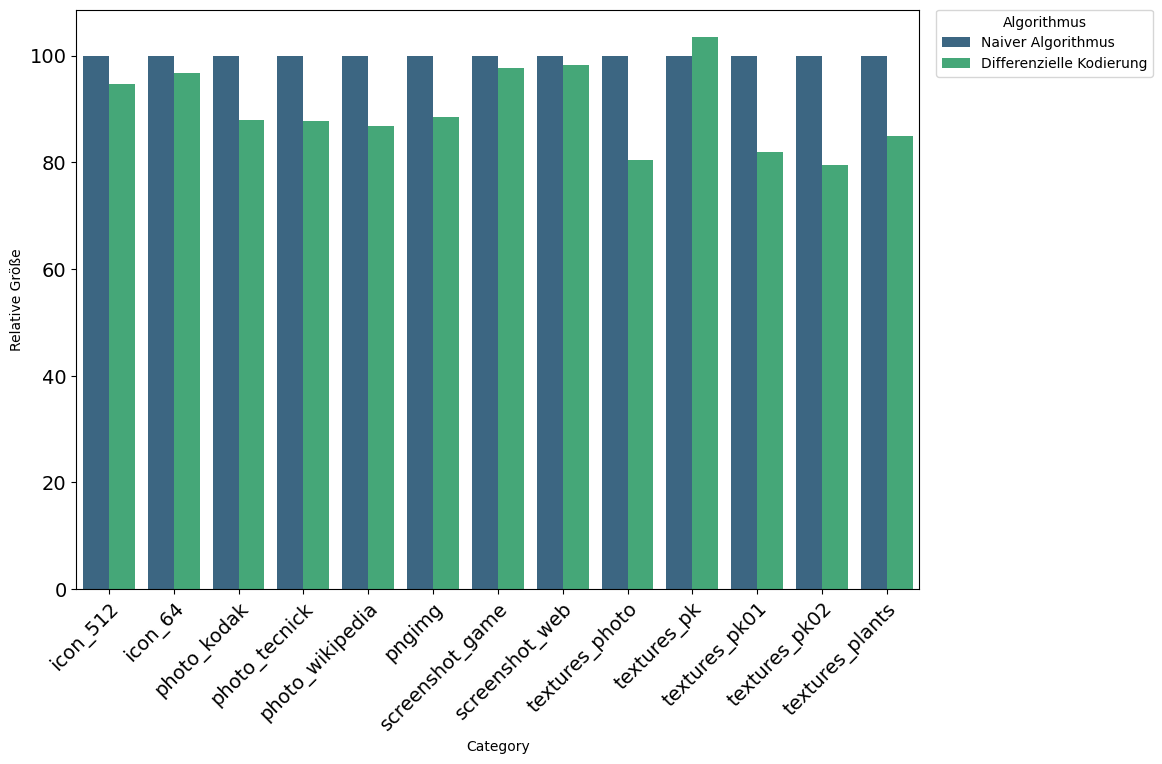

In [7]:
compare_results(sizes_simple1, sizes_differential1, "Naiver Algorithmus", "Differenzielle Kodierung", "color_compare_highqual.png")

In [8]:
sizes_simple25 = compute_total_sizes(pc.SIMPLE, 25)
sizes_differential25 = compute_total_sizes(pc.DIFFERENTIAL, 25)

Processing: 100%|██████████| 18/18 [00:03<00:00,  4.93it/s]
13it [04:53, 22.59s/it]
Processing: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]
13it [04:55, 22.73s/it]


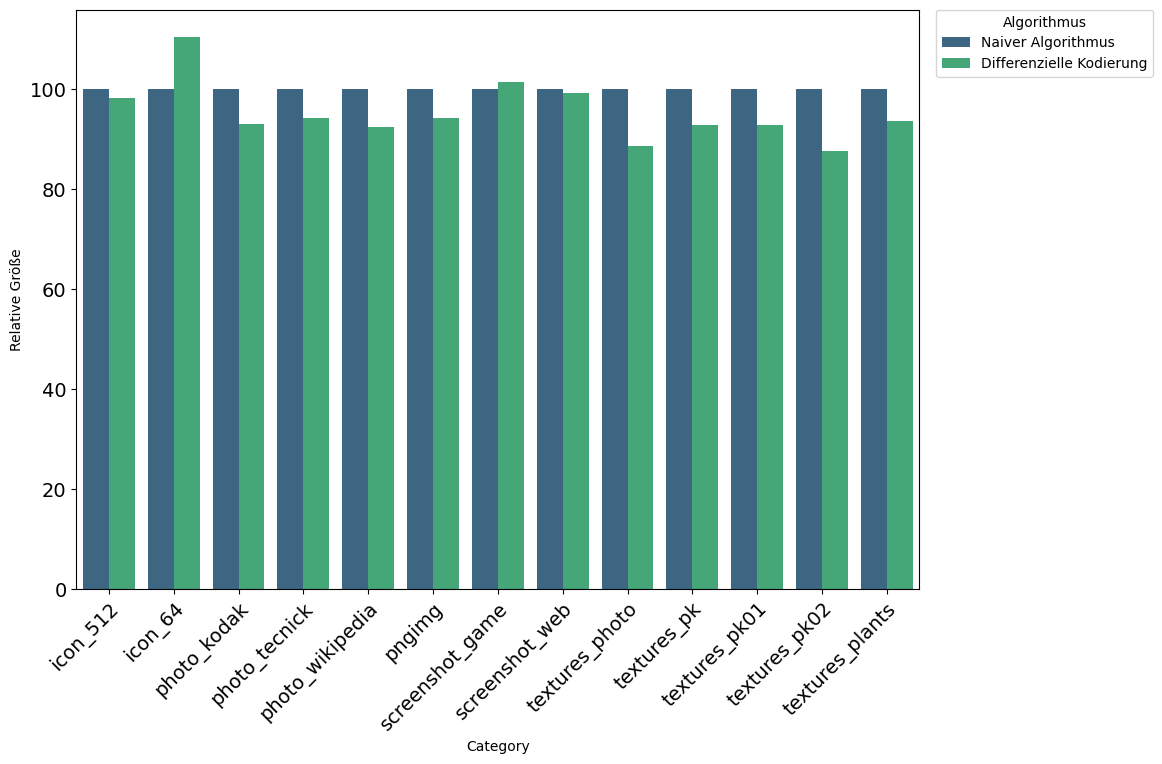

In [9]:
compare_results(sizes_simple25, sizes_differential25, "Naiver Algorithmus", "Differenzielle Kodierung", "color_compare_medium.png")